In [13]:
import pandas as pd
import numpy as np
import pickle
import random

In [204]:
df = pd.read_csv('../data/csv/triplet_embeddings.csv')
df.shape

(7994, 4097)

In [205]:
# for baseline

# df = df.drop(df.columns[1:553], axis=1)
# df.shape

In [206]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [207]:
df_info = pd.read_csv('../data/csv/info.csv')
df_info.sample(5)

,id,artist,title,genre,track,tags,test
4832,112317,Cloudkicker,Signal/Noise,Rock,112317.mp3,"['rock', 'experimental', '10 of 10 stars', 'dj...",0
6631,62594,Tchakare Kanyembe,Tchakare Kanyembe track 07,International,062594.mp3,"['international', 'afro-beat', 'african', 'afr...",0
2064,107127,Marrach,Moving Rocks,Electronic,107127.mp3,"['electronic', 'trip-hop', 'dubstep']",0
3587,32760,Christophe Marc,Bury The Doubt,Pop,032760.mp3,"['pop', 'rock', 'folk', 'christophe marc', 'fr...",0
592,91958,Graeme Mark,Catch The Knife,Folk,091958.mp3,"['singer songwriter', 'folk', 'singer-songwrit...",0


In [208]:
# new_test = list()
# while len(new_test) < 3:
#     idx = random.choice(df_info.index)
#     row = df_info.loc[idx]
#     if row['test'] == 1:
#         continue
#     if len(eval(row['tags'])) < 10:
#         continue
#     if idx not in new_test:
#         new_test.append(idx)
        
# for idx in new_test:
#     df_info.loc[idx, 'test'] = 1

# df_info.to_csv('../data/csv/info.csv', index=False)
    


In [209]:
df_info[df_info['test'] == 1].shape

(100, 7)

In [210]:
df_test = df_info[df_info['test'] == 1][['id']].merge(df, how='left', on='id')
df_test.shape

(100, 4097)

In [211]:
df_train = df_info[df_info['test'] == 0][['id']].merge(df, how='left', on='id')
df_train.dropna(inplace=True)
df_train.shape

(7894, 4097)

In [212]:
X_train = df_train.drop(columns=['id']).values
X_test = df_test.drop(columns=['id']).values

In [213]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [214]:
X_test.shape

(100, 4096)

In [215]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    f_score = 0
    iou = 0
    query_id = int(df_test.iloc[query_idx].id)
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].id)
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        f_score += score
        
        iou += len(set(answer_tags) & set(query_tags)) / len(set(answer_tags) | set(query_tags))
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant, f_score, iou

def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].id)
        if track in relevant_list:
            dcg += 1 / np.log2(i + 2)
        idcg += 1 / np.log2(i + 2)
    ndcg = dcg / idcg
    return ndcg



In [216]:
from sklearn.metrics import pairwise_distances
cnn = list()
for dist in ['euclidean']:
    dist_mtx = pairwise_distances(X_test, X_train, metric=dist)
    mean_ap = 0
    mean_f_score = 0
    mean_iou = 0
    ndcg = 0
    for i in range(100):
        arr = dist_mtx[i]
        neighbors = arr.argsort()[:10]
        relevant_num, relevant_list, f_score, iou = count_good_recommend(i, neighbors, trhold=0.4)
#         print(relevant_list)
        p_at_10 = relevant_num / 10
        mean_f_score += f_score / 10
        mean_iou += iou / 10
        cnn.append(p_at_10)
        mean_ap += p_at_10
        ndcg += count_ndcg(neighbors, relevant_list[1:])
    mean_f_score /= 100
    mean_iou /= 100
    mean_ap /= 100 
    mean_ndcg = ndcg / 100
    
    print(dist, mean_ap, mean_ndcg, mean_f_score, mean_iou)

euclidean 0.14799999999999996 0.16417490763945908 0.22727481603205124 0.16471379099125097


In [147]:
random.seed(3214)
rand = list()
ap = 0
ndcg = 0
mean_f_score = 0
mean_iou = 0
# for i in range(100):
#     mean_ap = 0
#     ndcg = 0
for i in range(100):
    test_track = df_test.iloc[i].id
    test_track_genre = main_dict[int(test_track)]['genre']
    genre_recommendations = list()
    while len(genre_recommendations) < 10:
        idx = random.randint(0, df_train.shape[0] - 1)
        track = df_train.iloc[idx].id
        track_genre = main_dict[int(track)]['genre']
        if track_genre == test_track_genre:
            genre_recommendations.append(idx)
#     print(i)

    relevant_num, relevant_list, f_score, iou = count_good_recommend(i, genre_recommendations, trhold=0.4)
#     print(test_track, relevant_list)
    mean_f_score += f_score / 10
    mean_iou += iou / 10
    p_at_10 = relevant_num / 10
    rand.append(p_at_10)
    mean_ap += p_at_10
    ndcg += count_ndcg(genre_recommendations, relevant_list[1:])
mean_f_score /= 100
mean_ap /= 100 
mean_ndcg = ndcg / 100
mean_iou /= 100
# ap += mean_ap
# ndcg += mean_ndcg
print(mean_ap, mean_ndcg, mean_f_score, mean_iou)

0.06565060303060606 0.06573704099278342 0.19637614369304376 0.11527028732447048


In [145]:
random.seed(3214)
ap = 0
ndcg = 0
mean_f_score = 0
mean_iou = 0
# for i in range(100):
#     mean_ap = 0
#     ndcg = 0
for i in range(100):
    test_track = df_test.iloc[i].id
    recommendations = list()
    while len(recommendations) < 10:
        idx = random.randint(0, df_train.shape[0] - 1)
        track = df_train.iloc[idx].id
        recommendations.append(idx)
#     print(i)

    relevant_num, relevant_list, f_score, iou = count_good_recommend(i, recommendations, trhold=0.4)
#     print(test_track, relevant_list)
    mean_f_score += f_score / 10
    mean_iou += iou / 10
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(recommendations, relevant_list[1:])
mean_f_score /= 100
mean_ap /= 100 
mean_ndcg = ndcg / 100
mean_iou /= 100
# ap += mean_ap
# ndcg += mean_ndcg
print(mean_ap, mean_ndcg, mean_f_score, mean_iou)

0.006030306060606656 0.006292869794644199 0.06648949175640309 0.03734771994281534


In [237]:
np.mean(base), np.mean(cnn)

(0.11199999999999999, 0.14800000000000002)

In [233]:
# for i in zip(base, cnn):
#     print(i)

In [219]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import seaborn as sns
import numpy as np

In [220]:
len(cnn), len(base)

(100, 100)

In [247]:
ttest_ind(base, rand)

Ttest_indResult(statistic=2.6170329779813444, pvalue=0.009554422914393252)

In [248]:
mannwhitneyu(base, rand)

MannwhitneyuResult(statistic=4283.0, pvalue=0.026921651557702733)

In [234]:
shapiro(cnn)

ShapiroResult(statistic=0.8392829895019531, pvalue=4.860615909763055e-09)

In [235]:
shapiro(base)

ShapiroResult(statistic=0.7614901065826416, pvalue=1.9053134070468047e-11)

In [244]:
minus = [-x for x in rand]

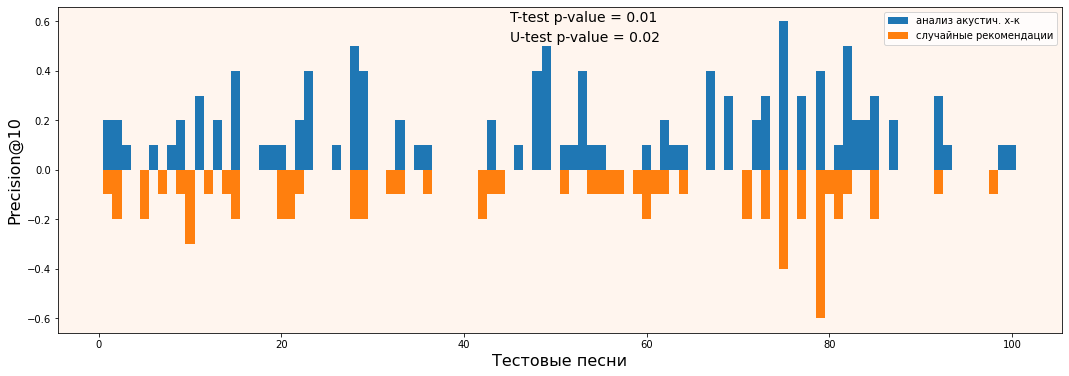

In [251]:
import seaborn as sns

# data = pd.DataFrame({'Baseline': base, 'CNN': rand})
x = range(1,101)
y1 = base
y2 = minus
fig, ax = plt.subplots()
ax.bar(x, y1, width=1)
ax.bar(x, y2, width=1)
ax.text(45, 0.6,'T-test p-value = 0.01', fontsize=14)
ax.text(45, 0.52,'U-test p-value = 0.02', fontsize=14)

ax.set_facecolor('seashell')
# fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.xlabel('Тестовые песни', fontsize=16)
plt.ylabel('Precision@10', fontsize=16)
plt.legend(['анализ акустич. х-к', 'случайные рекомендации'])
plt.show()
# plt.bar(, base)